In [1]:
import torch as th
from tint.attr import DynaMask
from tint.models import MLP
import xarray as xr
import numpy as np
import joblib
th.manual_seed(16)

from modelClass3 import CustomLSTM
import torch.nn as nn

/home/mfroelich/.conda/envs/explainable/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_dict = th.load('/home/mfroelich/Thesis/LSTM_final/models/best_model.pth')
model = CustomLSTM(3,3,48,True,8)
model.load_state_dict(model_dict)
model.eval()

CustomLSTM(
  (lstm): LSTM(3, 48)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=48, out_features=24, bias=True)
)

In [65]:
ds = xr.open_dataset('/net/litho/atmosdyn2/mfroelich/TS_TX1day_mean-lvl',
                     chunks={'year':1,'lat':361,'lon':721,'trajtime':121})[['adv','adiab','diab']]
sub = ds.sel({'year':1989,'lat':30,'lon':-65},drop=True)
sub = sub.fillna(0)
sub = np.stack((sub['adv'].values,sub['adiab'].values,sub['diab'].values),axis=-1)
input = sub[:113,:]
output = sub[-8:,:]

In [66]:
adv_scaler = joblib.load('/home/mfroelich/Thesis/LSTM_results/scalerAdv.gz')
adiab_scaler = joblib.load('/home/mfroelich/Thesis/LSTM_results/scalerAdiab.gz')
diab_scaler = joblib.load('/home/mfroelich/Thesis/LSTM_results/scalerDiab.gz')

input_trans = np.stack((adv_scaler.transform(input[:,[0]]),
                        adiab_scaler.transform(input[:,[1]]),
                        diab_scaler.transform(input[:,[2]])),axis=-1)

In [67]:
with th.no_grad():
    pred_trans, h = model(th.Tensor(input_trans))

print(h.shape)

pred = np.stack((adv_scaler.inverse_transform(pred_trans[:,0,[0]]),
                adiab_scaler.inverse_transform(pred_trans[:,0,[1]]),
                diab_scaler.inverse_transform(pred_trans[:,0,[2]])),axis=-1)

torch.Size([113, 1, 48])


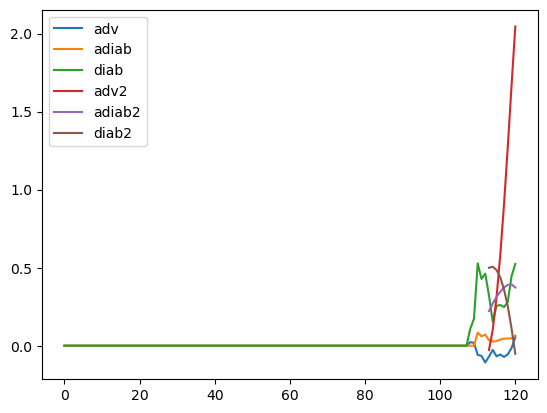

In [68]:
import matplotlib.pyplot as plt
x = np.stack((range(0,121),range(0,121),range(0,121)),axis=-1)
plt.plot(x,sub,label=['adv','adiab','diab'])
plt.plot(x[-8:,:],pred.squeeze(),label=['adv2','adiab2','diab2'])
plt.legend()

Now, need to get the SAME but when processing with batch_first configuration. We need to modify the forward pass to reshape first:

In [69]:
class ModifiedLSTMModel(CustomLSTM):
    def __init__(self,input_size, out_dim,hidden_size, init_zero, forecast_steps):
        super(ModifiedLSTMModel, self).__init__(input_size, out_dim,hidden_size, init_zero, forecast_steps)
    
        self.lstm = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=1,
                dtype=th.float,
                batch_first=True)
    
    def forward(self,seq):
        hidden, (_, _) = self.lstm(seq,(th.zeros(self.num_layers, seq.shape[0], self.hidden_size, dtype=th.float),
                                        th.zeros(self.num_layers, seq.shape[0], self.hidden_size, dtype=th.float))) # hidden has shape (seq_length,batch_size,hidden_size), hidden[-1].shape = (batch_size,hidden_size)
        out = self.dropout(hidden[:,-1,:])
        out = self.linear(out)
        out = out.view(seq.shape[0],self.forecast_steps,-1) # formatting
        return out

model_batch_first = ModifiedLSTMModel(3,3,48,True,8)
model_batch_first.load_state_dict(model.state_dict())

<All keys matched successfully>

In [70]:
batch_first_input_trans = th.Tensor(input_trans).permute(1,0,2)

model_batch_first.eval()
with th.no_grad():
    batch_first_pred_trans = model_batch_first(batch_first_input_trans)

batch_first_pred = np.stack((adv_scaler.inverse_transform(batch_first_pred_trans[0,:,[0]]),
                adiab_scaler.inverse_transform(batch_first_pred_trans[0,:,[1]]),
                diab_scaler.inverse_transform(batch_first_pred_trans[0,:,[2]])),axis=-1)


We are good!

In [71]:
explainer = DynaMask(model_batch_first)
attr = explainer.attribute(batch_first_input_trans)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mfroelich/.conda/envs/explainable/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | net   | Mask    | 339    | train
1 | _loss | MSELoss | 0      | train
------------------------------------------
339       Trainable params
0         Non-trainable params
339       Total params
0.001     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode
/home/mfroelich/.conda/envs/explainable/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in th

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 74.08it/s, v_num=9] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 49.90it/s, v_num=9]


/home/mfroelich/.conda/envs/explainable/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 243.08it/s]


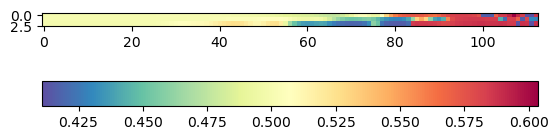

In [72]:
plt.imshow(attr.squeeze().permute(1,0),cmap='Spectral_r')
plt.colorbar(orientation='horizontal')